## Manipulator Kinematics ##

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Circle
from IPython.display import display, clear_output
import numpy as np
import cv2
import time
import operator

In [2]:
import sys
sys.path.append("C:/Users/Mafeus/Desktop/Git_Repos/OpenCV")
import OpCV_Utils

In [3]:
import manipulator_diagram as m_diagram

In [4]:
def config_axis(ax):
    
    Xmin, Xmax = 0, 400
    Ymin, Ymax = 0, 400
    Zmin, Zmax = 0, 200

    ax.set_xlabel('\n X ', fontsize=15)
    ax.set_ylabel('\n Y ', fontsize=15)
    ax.set_zlabel('\n Z ', fontsize=15)

    ax.set_xticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    ax.set_yticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    ax.set_zticks([0, 50, 100, 150, 200])
    ax.dist = 12

    ax.set_xlim([Xmin, Xmax])
    ax.set_ylim([Ymin, Ymax])
    ax.set_zlim([Zmin, Zmax])

    ax.set_title('Manipulator Kinematics Diagram', fontsize=15)

    ax.quiver(Xmin, 0, 0, Xmax, 0, 0, arrow_length_ratio = 0.05, color='k')
    ax.quiver(0, Ymin, 0, 0, Ymax, 0, arrow_length_ratio = 0.05, color='k')
    ax.quiver(0, 0, Zmin, 0, 0, Zmax, arrow_length_ratio = 0.05, color='k')

End Effector Position: 382.96700394873926 223.44664457459191 295.17540966287265


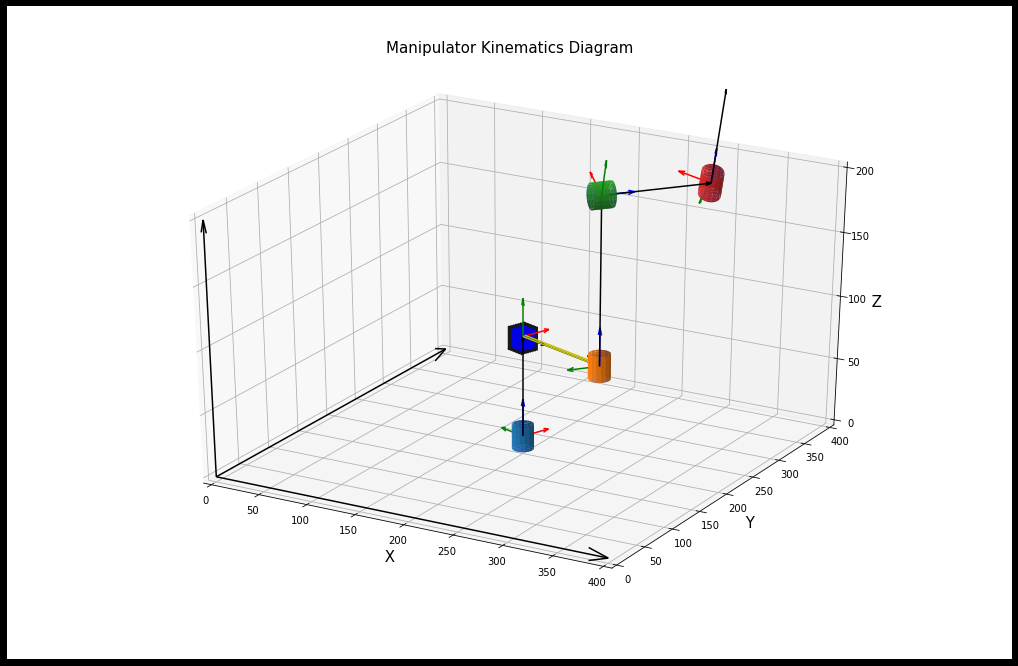

In [5]:
# Graph Properties:
fig = plt.figure(figsize=(18,12), facecolor='k')
ax = fig.add_subplot(111, projection='3d')

# Initial Positions:
theta1 = 0
theta2 = 0
theta4 = 0
theta5 = 0
L3 = 80; i = 1
f1 = 1
f2 = 1
f4 = 1
f5 = 1

while True:
    
    config_axis(ax)
        
    #########################
    # Movement over time:
    
    # Revolute:
    theta1+=5*f1
    theta2+=5*f2
    theta4+=5*f4
    theta5+=5*f5
    
    if (theta1 >= 90):
        f1 = -1
    if (theta1 <= -90):
        i = 1
        
    if (theta2 >= 90):
        f2 = -1
    if (theta2 <= -90):
        f2 = 1
        
    if (theta4 >= 45):
        f4 = -1
    if (theta4 <= -45):
        f4 = 1
        
    if (theta5 >= 60):
        f5 = -1
    if (theta4 <= -60):
        f5 = 1

    # Prismatic:
    L3+=3*i
    if (L3 > 110):
        i = -1
    if (L3 < 80):
        i = 1
    ########################
    
    # Frame 1:
    F1_orientation = (0,0,0)
    F1_mov_angle   = theta1
    x, y, z        = 200, 200, 10
    F1_jointType   = 'Revolute Joint'
    Link1          = 80
    d1_min         = -90
    d1_max         = 90

    # Frame 2:
    Link2          = L3
    F2_orientation = (90,0,0)
    F2_mov_angle   = 0
    F2_jointType   = 'Prismatic Joint'
    d2_min         = 80
    d2_max         = 120

    # Frame 3:
    Link3          = 130
    F3_orientation = (0,0,0)
    F3_mov_angle   = theta2
    F3_jointType   = 'Revolute Joint'
    d3_min         = -60
    d3_max         = 60

    # Frame 4:
    Link4          = 100
    F4_orientation = (90,0,0)
    F4_mov_angle   = theta4
    F4_jointType   = 'Revolute Joint'
    d4_min         = -90
    d4_max         = 90

    # Frame 5:
    Link5          = 80
    F5_orientation = (0,0,0)
    F5_mov_angle   = theta5
    F5_jointType   = 'Revolute Joint'
    d5_min         = -90
    d5_max         = 90

    frameOne   = [x, y, z, F1_orientation, F1_mov_angle, F1_jointType, Link1, d1_min, d1_max]
    frameTwo   = [Link2, F2_orientation, F2_mov_angle, F2_jointType, d2_min, d2_max]
    frameThree = [Link3, F3_orientation, F3_mov_angle, F3_jointType, d3_min, d3_max]
    frameFour  = [Link4, F4_orientation, F4_mov_angle, F4_jointType, d4_min, d4_max]
    frameFive  = [Link5, F5_orientation, F5_mov_angle, F5_jointType, d5_min, d5_max]

    frame_list = [frameOne, frameTwo, frameThree, frameFour, frameFive]
   
    end_effector_x, end_effector_y, end_effector_z = m_diagram.kinematics_diagram(ax, frame_list)
    
    clear_output(wait=True)
    
    print("End Effector Position:", end_effector_x, end_effector_y, end_effector_z)
    
    fig.canvas.draw()
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)

    cv2.imshow("Grid", img)
    
    key = cv2.waitKey(1) or 0xff   
    if key == ord('k'):
        break

    ax.cla()
            
cv2.destroyAllWindows()

In [6]:
def dist(x1, y1, z1, x2, y2, z2):
    
    distance = np.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1) + (z2-z1)*(z2-z1))
    
    return distance

In [7]:
def search(x_goal, y_goal, z_goal, frame_list, inc_factor=20):
    
    # Graph Properties:
    fig = plt.figure(figsize=(18,12), facecolor='k')
    ax = fig.add_subplot(111, projection='3d')

    config_axis(ax)
    
    frameOne = frame_list[0]
        
    distance_list = []
    displacement_list = []
    
    d_min = frameOne[7]
    d_max = frameOne[8]
    
    
    for d in np.arange(d_min, d_max, (d_max - d_min)/inc_factor):
                
        if frameOne[5] == 'Revolute Joint':
            frame_list[0][4] = d
            
        if frameOne[5] == 'Prismatic Joint':
            frame_list[0][6] = d
            
        x, y, z = m_diagram.kinematics_diagram(ax, frame_list)
        
        distance = dist(x_goal, y_goal, z_goal, x, y, z)
        
        distance_list.append(distance)
        displacement_list.append(d)
        
        #######################################################################
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        img = img[130:760, 270:1100]

        cv2.imshow("Grid", img)
        cv2.waitKey(1)

        ax.cla()
        config_axis(ax)
        #######################################################################
        
    pos = np.argmin(distance_list)
    best_displacement = displacement_list[pos]
    
    if frameOne[5] == 'Revolute Joint':
        frame_list[0][4] = best_displacement
        results = [[frame_list[0][4]]]
            
    if frameOne[5] == 'Prismatic Joint':
        frame_list[0][6] = best_displacement
        results = [[frame_list[0][6]]]    
        
    #############################################################################################
        
    for n, frame in enumerate(frame_list):
        
        if (n > 0):
            
            distance_list = []
            displacement_list = []
    
            d_min = frame[4]
            d_max = frame[5]
            
            for d in np.arange(d_min, d_max, (d_max - d_min)/inc_factor):
        
                if frame[3] == 'Revolute Joint':
                    frame_list[n][2] = d
                    
                if frame[3] == 'Prismatic Joint':
                    frame_list[n][0] = d

                x, y, z = m_diagram.kinematics_diagram(ax, frame_list)

                distance = dist(x_goal, y_goal, z_goal, x, y, z)
                
                distance_list.append(distance)
                displacement_list.append(d)
                
                #######################################################################
                fig.canvas.draw()
                img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
                img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
                img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
                img = img[130:760, 270:1100]

                cv2.imshow("Grid", img)
                cv2.waitKey(1)
                                
                ax.cla()                    
                config_axis(ax)
                #######################################################################
                        
            pos = np.argmin(distance_list)
            best_displacement = displacement_list[pos]
            
            if frame[3] == 'Revolute Joint':
                frame_list[n][2] = best_displacement
                results.append([frame_list[n][2]])
            
            if frame[3] == 'Prismatic Joint':
                frame_list[n][0] = best_displacement
                results.append([[frame_list[n][0]]])                
       
    cv2.putText(img, 'DONE', (200,200), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 50, 50), 2)
    cv2.imshow("Grid", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    OpCV_Utils.show_single_img_plt(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 'Result Pos', fig_size=(18,12))
    
    return results, (x,y,z)

Displacement Results: [[-90.0], [[80.0]], [18.0], [-90.0], [-90.0]]
End Effector Posistion: (68.63683824638352, 99.19411914639194, 170.0)  Desired Pos: (100, 200, 150)


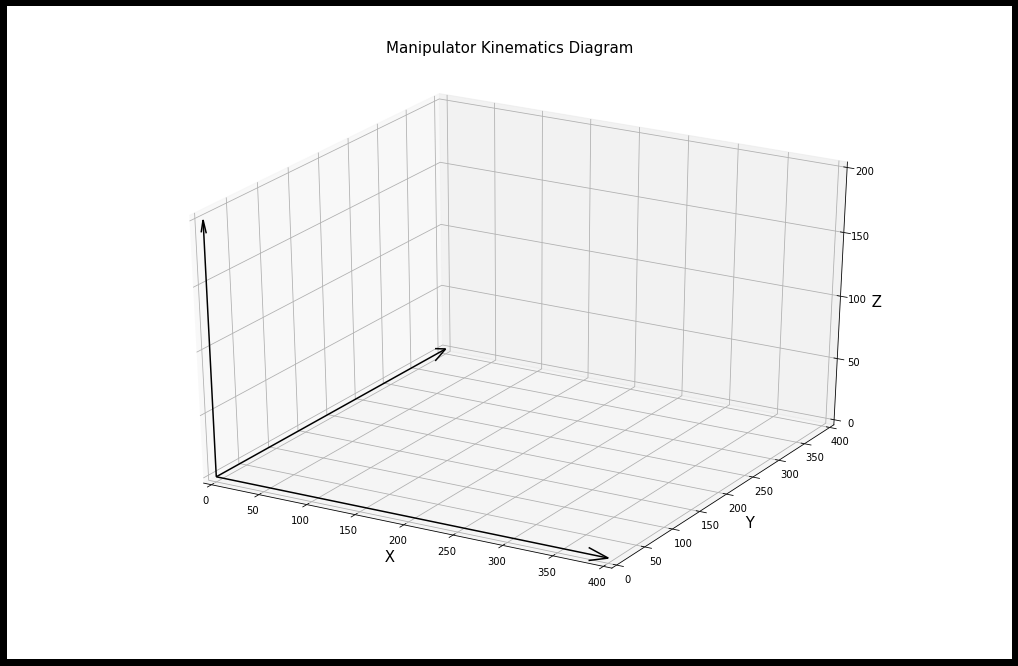

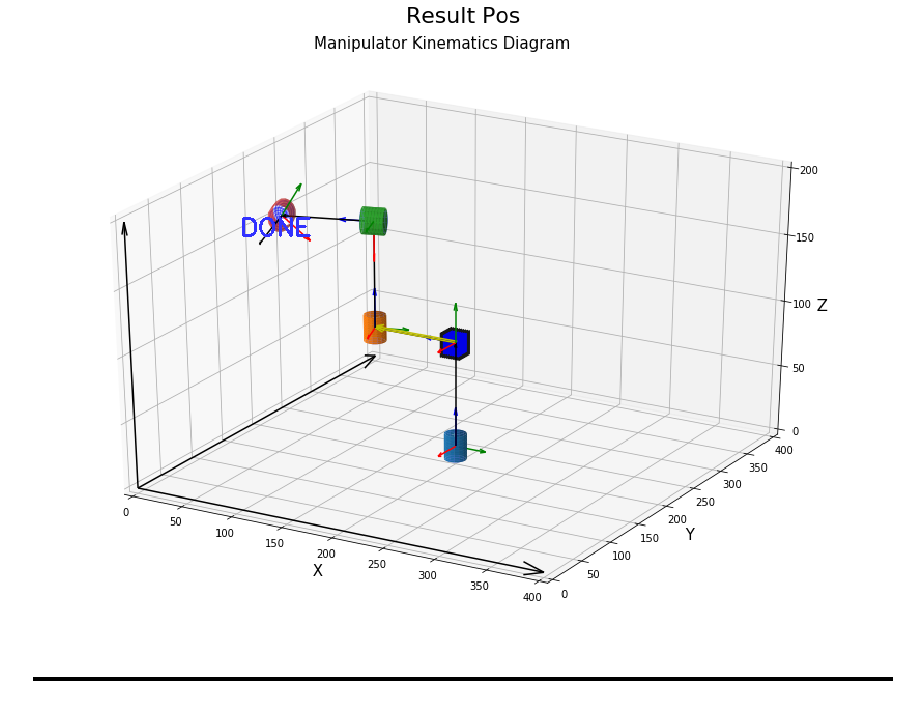

In [8]:
# Frame 1:
F1_orientation = (0,0,0)
F1_mov_angle   = 0
x, y, z        = 200, 200, 10
F1_jointType   = 'Revolute Joint'
Link1          = 80
d1_min         = -90
d1_max         = 90
    
# Frame 2:
Link2          = 80
F2_orientation = (90,0,0)
F2_mov_angle   = 0
F2_jointType   = 'Prismatic Joint'
d2_min         = 80
d2_max         = 140
    
# Frame 3:
Link3          = 80
F3_orientation = (0,0,0)
F3_mov_angle   = 0
F3_jointType   = 'Revolute Joint'
d3_min         = -90
d3_max         = 90
        
# Frame 4:
Link4          = 80
F4_orientation = (90,0,0)
F4_mov_angle   = 0
F4_jointType   = 'Revolute Joint'
d4_min         = -90
d4_max         = 90
    
# Frame 5:
Link5          = 80
F5_orientation = (0,0,0)
F5_mov_angle   = 0
F5_jointType   = 'Revolute Joint'
d5_min         = -90
d5_max         = 90
    
frameOne   = [x, y, z, F1_orientation, F1_mov_angle, F1_jointType, Link1, d1_min, d1_max]
frameTwo   = [Link2, F2_orientation, F2_mov_angle, F2_jointType, d2_min, d2_max]
frameThree = [Link3, F3_orientation, F3_mov_angle, F3_jointType, d3_min, d3_max]
frameFour  = [Link4, F4_orientation, F4_mov_angle, F4_jointType, d4_min, d4_max]
frameFive  = [Link5, F5_orientation, 0, F5_jointType, d5_min, d5_max]

frame_list = [frameOne, frameTwo, frameThree, frameFour, frameFive]

x_goal = 100
y_goal = 200
z_goal = 150
    
results, end_effector = search(x_goal, y_goal, z_goal, frame_list, inc_factor=5)
    
print('Displacement Results:', results)
print('End Effector Posistion:', end_effector, ' Desired Pos:', (x_goal, y_goal, z_goal))
    